In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *

from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *

from pref_voting.utility_profiles import UtilityProfile

from pref_voting.generate_utility_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.utility_methods import *

from pref_voting.spatial_profiles import SpatialProfile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_functions import *
from tqdm.notebook import tqdm


In [2]:
sum([50, 60, 70, 80, 90, 100, 110])

560

In [3]:
uprof = UtilityProfile([{0: u} for u in  [50, 60, 70, 80, 90, 100, 110]])

uprof.display()

uprof.normalize_by_range().display()

uprof.normalize_by_standard_score().display()

util_avg = uprof.avg_utility_function()

for x in uprof.domain: 
    print(x, util_avg(x))

  Voter    0
-------  ---
      1   50
      2   60
      3   70
      4   80
      5   90
      6  100
      7  110
  Voter    0
-------  ---
      1    0
      2    0
      3    0
      4    0
      5    0
      6    0
      7    0
  Voter     0
-------  ----
      1  -1.5
      2  -1
      3  -0.5
      4   0
      5   0.5
      6   1
      7   1.5
0 80.0


In [4]:
up = generate_spatial_profile(3, 3, 2).to_utility_profile()

up.display()
up.normalize_by_range().display()

up.normalize_by_standard_score().display()

  Voter         0          1         2
-------  --------  ---------  --------
      1  -2.1395    -2.54633  -4.00001
      2  -5.53307  -13.5762   -1.51903
      3  -3.25269   -5.87925  -2.7703
  Voter         0         1    2
-------  --------  --------  ---
      1  1         0.781335    0
      2  0.667082  0           1
      3  0.844838  0           1
  Voter         0          1            2
-------  --------  ---------  -----------
      1   1.06356   1.03652   -1.22118
      2  -1.33901  -1.35146    1.22828
      3   0.27545   0.314939  -0.00709659


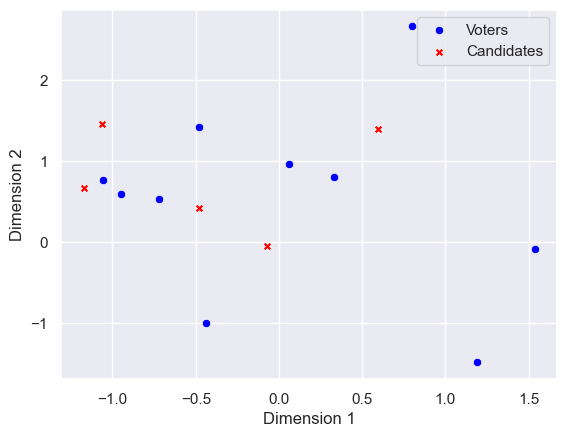

In [5]:
sp = generate_spatial_profile(5, 10, 2)

sp.view()

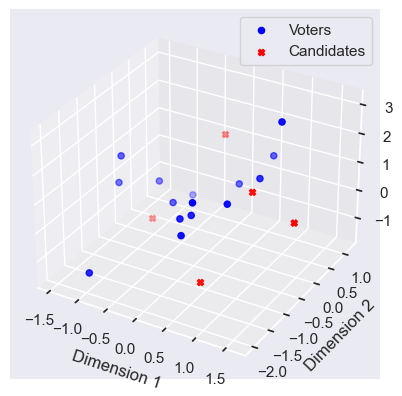

Candidates: 
Candidate  0  position:  [ 0.86812405 -0.25538674  0.99285295]
Candidate  1  position:  [-1.11896748  0.1723856  -1.56006909]
Candidate  2  position:  [-0.36314645  1.17251125  0.96821783]
Candidate  3  position:  [ 1.60846069 -0.33436596  0.45088848]
Candidate  4  position:  [ 0.50636516 -1.19410124 -1.42824733]

Voters: 
Voter  0  position:  [-1.40226583 -0.27082625  0.97632268]
Voter  1  position:  [0.21200033 0.56111708 0.10423817]
Voter  2  position:  [-0.92325371 -2.02312181 -1.11558208]
Voter  3  position:  [ 0.73328107 -0.79387147  1.03942944]
Voter  4  position:  [0.59251505 0.96468597 0.93783341]
Voter  5  position:  [-1.04464029  0.26942171 -0.23969582]
Voter  6  position:  [ 0.07636276 -1.04847216  0.38915622]
Voter  7  position:  [ 0.38026194 -1.20823012  1.28931043]
Voter  8  position:  [ 0.20513462 -0.93636948  0.47535051]
Voter  9  position:  [-1.4768109  -0.23070518 -0.05974135]
Voter  10  position:  [-0.83152123  0.95862106 -1.30380996]
Voter  11  positio

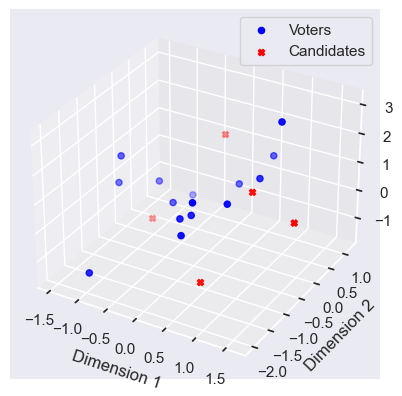

Candidates: 
Candidate  0  position:  [ 0.86812405 -0.25538674  0.99285295]
Candidate  1  position:  [-1.11896748  0.1723856  -1.56006909]
Candidate  2  position:  [-0.36314645  1.17251125  0.96821783]
Candidate  3  position:  [ 1.60846069 -0.33436596  0.45088848]
Candidate  4  position:  [ 0.50636516 -1.19410124 -1.42824733]

Voters: 
Voter  0  position:  [-1.40226583 -0.27082625  0.97632268]
Voter  1  position:  [0.21200033 0.56111708 0.10423817]
Voter  2  position:  [-0.92325371 -2.02312181 -1.11558208]
Voter  3  position:  [ 0.73328107 -0.79387147  1.03942944]
Voter  4  position:  [0.59251505 0.96468597 0.93783341]
Voter  5  position:  [-1.04464029  0.26942171 -0.23969582]
Voter  6  position:  [ 0.07636276 -1.04847216  0.38915622]
Voter  7  position:  [ 0.38026194 -1.20823012  1.28931043]
Voter  8  position:  [ 0.20513462 -0.93636948  0.47535051]
Voter  9  position:  [-1.4768109  -0.23070518 -0.05974135]
Voter  10  position:  [-0.83152123  0.95862106 -1.30380996]
Voter  11  positio

In [6]:
sp = generate_spatial_profile(5, 15, 3)
sp.view()
sp.display()
sp_str = sp.write()

sp2 = SpatialProfile.from_string(sp_str)

sp2.view()
sp2.display()


In [7]:
for t in range(100): 
    prof = generate_profile(4, 11)  
    print(split_cycle(prof)  ) 

[3]
[2]
[0, 1]
[0]
[2]
[3]
[0]
[3]
[0, 1, 3]
[0]
[2]
[3]
[3]
[2]
[1]
[1]
[1]
[3]
[1, 2, 3]
[1]
[1]
[0]
[1]
[0, 2, 3]
[0]
[3]
[1, 2]
[1, 3]
[3]
[0, 2, 3]
[3]
[3]
[0]
[1]
[0]
[0, 1, 2]
[1]
[1]
[0]
[0, 1, 2, 3]
[1]
[0]
[0]
[1]
[1]
[2]
[3]
[0]
[2]
[2]
[1]
[1]
[0]
[0]
[1]
[3]
[0]
[0]
[2]
[3]
[0]
[1, 2, 3]
[2]
[2]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0, 2, 3]
[3]
[2]
[0]
[0, 1, 3]
[0]
[2]
[3]
[3]
[2]
[0]
[2]
[2]
[3]
[0]
[1]
[3]
[1]
[3]
[1]
[0, 2, 3]
[0, 1, 3]
[0, 1]
[1]
[0]
[1]
[2, 3]
[1, 2]
[1, 2]


In [8]:

for t in range(100):
    for vm in [split_cycle, 
               stable_voting, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               simple_stable_voting, 
               iterated_split_cycle,
               copeland,
               borda, 
               plurality, 
               plurality_with_runoff, 
               instant_runoff, 
               coombs, 
               minimax, 
               strict_nanson, 
               bucklin]: 

        prof = generate_profile(5, 11)

        vm.display(prof)
        
        prof = generate_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()




Split Cycle winners are {1, 2, 4}
Split Cycle winners are {2, 3, 4}
Stable Voting winner is {1}
Stable Voting winner is {0}
Beat Path winner is {2}
Beat Path winners are {2, 3}
Beat Path winners are {1, 4}
Beat Path winner is {2}
Split Cycle winners are {0, 2, 3}
Split Cycle winners are {2, 3}
Simple Stable Voting winner is {2}
Simple Stable Voting winner is {1}
Iterated Split Cycle winner is {1}
Iterated Split Cycle winner is {3}
Copeland winner is {0}
Copeland winner is {3}
Borda winner is {3}
Borda winner is {4}
Plurality winners are {1, 2, 3}
Plurality winner is {3}
PluralityWRunoff winner is {3}
PluralityWRunoff winner is {0}
Instant Runoff winner is {1}
Instant Runoff winner is {0}
Coombs winner is {4}
Coombs winners are {3, 4}
Minimax winner is {3}
Minimax winner is {3}
Strict Nanson winner is {1}
Strict Nanson winners are {0, 2}
Bucklin winner is {4}
Bucklin winner is {1}

Split Cycle winner is {1}
Split Cycle winner is {2}
Stable Voting winner is {1}
Stable Voting winner is {4

In [9]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               plurality,
               stable_voting, 
               simple_stable_voting, 
               copeland,
               borda_for_profile_with_ties,
               instant_runoff_for_truncated_linear_orders
               ]: 

        prof = generate_truncated_profile(5, 11)

        vm.display(prof)
        prof = generate_truncated_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


Split Cycle winners are {1, 2, 3}
Split Cycle winners are {2, 3}
Beat Path winners are {0, 2}
Beat Path winners are {0, 4}
Beat Path winner is {1}
Beat Path winners are {2, 3}
Split Cycle winners are {1, 2, 4}
Split Cycle winner is {1}
Plurality winner is {3}
Plurality winners are {1, 2, 4}
Stable Voting winners are {0, 1}
Stable Voting winner is {1}
Simple Stable Voting winners are {0, 3}
Simple Stable Voting winner is {0}
Copeland winner is {4}
Copeland winner is {1}
Borda winner is {3}
Borda winner is {0}
Instant Runoff winner is {4}
Instant Runoff winner is {0}

Split Cycle winners are {1, 4}
Split Cycle winner is {3}
Beat Path winners are {0, 3, 4}
Beat Path winner is {0}
Beat Path winner is {3}
Beat Path winner is {1}
Split Cycle winners are {0, 2, 3}
Split Cycle winners are {2, 3}
Plurality winner is {4}
Plurality winner is {1}
Stable Voting winner is {4}
Stable Voting winners are {1, 4}
Simple Stable Voting winner is {1}
Simple Stable Voting winners are {3, 4}
Copeland winner i

In [10]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               stable_voting, 
               simple_stable_voting, 
               gocha,
               smith_set,
               copeland
               ]: 

        mg = generate_margin_graph(5)

        vm.display(mg)
        mg = generate_edge_ordered_tournament(4)
        vm.display(mg)

        mg = generate_edge_ordered_tournament_infinite_limit(5)
        vm.display(mg)


        ws_restricted = vm(mg, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


Split Cycle winner is {3}
Split Cycle winners are {2, 3}
Split Cycle winner is {0}
Beat Path winner is {1}
Beat Path winner is {2}
Beat Path winner is {4}
Beat Path winners are {1, 2}
Beat Path winner is {0}
Beat Path winner is {2}
Split Cycle winners are {0, 4}
Split Cycle winner is {0}
Split Cycle winner is {3}
Stable Voting winner is {3}
Stable Voting winner is {3}
Stable Voting winner is {4}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {0}
GOCHA winners are {0, 1, 3, 4}
GOCHA winners are {0, 1, 2, 3}
GOCHA winner is {4}
Smith Set winners are {0, 1, 2, 3, 4}
Smith Set winners are {0, 1, 2, 3}
Smith Set winner is {2}
Copeland winner is {2}
Copeland winner is {3}
Copeland winner is {4}

Split Cycle winners are {0, 3, 4}
Split Cycle winner is {2}
Split Cycle winner is {3}
Beat Path winner is {2}
Beat Path winner is {2}
Beat Path winner is {3}
Beat Path winner is {1}
Beat Path winner is {3}
Beat Path winner is {0}
Split Cycle winne

In [11]:
for t in range(100):
    for um in [sum_utilitarian,
                relative_utilitarian,
                maximin,
                lexicographic_maximin,
                nash,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        print(um(uprof))

        uprof = generate_utility_profile_normal(6, 20)
        print(um(uprof))

        uprof = generate_spatial_utility_profile(5, 11)
        print(um(uprof))

    print()


1 2 3 4 0 
5 2 3 4 1 0 
4 3 0 2 1 


AttributeError: 'Utility' object has no attribute 'normalize'

In [12]:
for t in range(100):
    for vm in [sum_utilitarian_ws,
                relative_utilitarian_ws,
                maximin_ws,
                lexicographic_maximin_ws,
                nash_ws,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        vm.display(uprof)

        uprof = generate_utility_profile_normal(6, 20)
        vm.display(uprof)

        uprof = generate_spatial_utility_profile(5, 11)
        vm.display(uprof)

        ws_restricted = vm(uprof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()


Sum Utilitarianism winner is {3}
Sum Utilitarianism winner is {3}
Sum Utilitarianism winner is {3}


AttributeError: 'Utility' object has no attribute 'normalize'